<img src="http://www.exalumnos.usm.cl/wp-content/uploads/2015/06/Isotipo-Negro.gif" title="Title text" width="20%" height="20%" />


<hr style="height:2px;border:none"/>
<h1 align='center'> INF-393 Máquinas de Aprendizaje II-2019 </h1>

<H3 align='center'> Tarea 3 - Ensamblados y modelos avanzados </H3>
<hr style="height:2px;border:none"/>

**Temas**  
* Técnicas de ensamblado: *bagging*, *boosting* y *random forest*.
* Ventajas de técnicas de ensamblados
* Problemas desbalanceados
 

**Formalidades**  
* Equipos de trabajo de: 2 personas (*cada uno debe estar en condiciones de realizar una presentación y discutir sobre cada punto del trabajo realizado*)
* Se debe preparar una presentación de 20 minutos. Presentador será elegido aleatoriamente.
* Se debe preparar un (breve) Jupyter/IPython notebook que explique la actividad realizada y las conclusiones del trabajo
* Fecha de entrega y cierre competencia: 17 de Enero
* Formato de entrega: envı́o de link Github al correo electrónico del ayudante (*<francisco.mena.13@sansano.usm.cl>*) , incluyendo al profesor en copia (*<jnancu@inf.utfsm.cl>*). Por favor especificar el siguiente asunto: [Tarea3-INF393-II-2019]

<hr style="height:2px;border:none"/>

La tarea se divide en secciones:

[1.](#primero) Ensamblados para regresión  
[2.](#segundo) Detección de acoso en *Twitter*  

<a id="primero"></a>
## 1. Ensamblados para regresión
---
Las técnicas de ensamblados vistos en clases pueden ser aplicadas tanto a problemas de clasificación o regresión, teniendo la ventaja de utilizar múltiples modelos de aprendizaje para utilizar la ventaja de cada uno. En este actividad se trabajará con predecir la temperatura media de un día, dada cierta información del día anterior, como la humedad, velocidad del viento, presión atmosférica, fecha y temperatura. El modelo predictor derivado puede ser bastante útil para conocer el comportamiento del clima a lo largo del tiempo.

<img src="https://scijinks.gov/review/forecast-reliability/forecast-reliability2.jpg" title="Title text" width="70%"  />

Los datos de clima son recolectados en la ciudad Delhi de India por un período de 4 años (2013 a 2017), proporcionados en Kaggle a través del siguiente __[link](https://www.kaggle.com/sumanthvrao/daily-climate-time-series-data)__, las particiones de entrenamiento y prueba están dadas. El registro de cada dato corresponde a un día, incrementando a través de las filas por cada día.

---
    
>  Cargue los datos en un dataframe de pandas, además agregue una columna indicando el valor a predecir, la temperatura media del día siguiente. *Como el último dato/registro no tiene un valor a predecir éste se elimina*.
```python
import pandas as pd
df = pd.read_csv("DailyDelhiClimateTrain.csv")
df["y_value"] = df["meantemp"].shift(-1)
df = df.iloc[:-1] #remove last row
```

In [2]:
import pandas as pd
df = pd.read_csv("DailyDelhiClimateTrain.csv")
df["y_value"] = df["meantemp"].shift(-1)
df = df.iloc[:-1] #remove last row
df

,date,meantemp,humidity,wind_speed,meanpressure,y_value
0,2013-01-01,10.000000,84.500000,0.000000,1015.666667,7.400000
1,2013-01-02,7.400000,92.000000,2.980000,1017.800000,7.166667
2,2013-01-03,7.166667,87.000000,4.633333,1018.666667,8.666667
3,2013-01-04,8.666667,71.333333,1.233333,1017.166667,6.000000
4,2013-01-05,6.000000,86.833333,3.700000,1016.500000,7.000000
...,...,...,...,...,...,...
1456,2016-12-27,16.850000,67.550000,8.335000,1017.200000,17.217391
1457,2016-12-28,17.217391,68.043478,3.547826,1015.565217,15.238095
1458,2016-12-29,15.238095,87.857143,6.000000,1016.904762,14.095238
1459,2016-12-30,14.095238,89.666667,6.266667,1017.904762,15.052632


> Debido a la poca información que se tiene a través de los 4 parámetros medidos, extraíga más información a través de los datos de fecha. Por ejemplo, el comportamiento a través de los meses y años varía, así como la información de la temporada del año podría ayudar a la predicción. Decida si puede incluir más información a partir de la fecha que tenga sentido con el problema.
```python
...#procesamiento de fecha(datetime/timestamp) a numeros
df["date"] = pd.to_datetime(df["date"])
df['cday'] = df['date'].dt.dayofweek #0:lunes,6:domingo
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month #1:enero, 12: diciembre
...#based on: https://en.wikipedia.org/wiki/Climate_of_India
seasons = ["winter","winter","summer","summer","summer","rainy","rainy","rainy","fall","fall","fall","winter"]
df['season'] = [ seasons[month_i - 1] for month_i in df['month'].values ]
df = pd.get_dummies(df,columns=['season']) #to one hot.. as nominal variable
... #any more information?
df.drop(["date"], axis=1, inplace=True) #delete date
```

In [3]:
#procesamiento de fecha(datetime/timestamp) a numeros
df["date"] = pd.to_datetime(df["date"])
df['cday'] = df['date'].dt.dayofweek #0:lunes,6:domingo
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month #1:enero, 12: diciembre
#based on: https://en.wikipedia.org/wiki/Climate_of_India
seasons = ["winter","winter","summer","summer","summer","rainy","rainy","rainy","fall","fall","fall","winter"]
df['season'] = [ seasons[month_i - 1] for month_i in df['month'].values ]
df = pd.get_dummies(df,columns=['season']) #to one hot.. as nominal variable
#any more information?
df.drop(["date"], axis=1, inplace=True) #delete date
df_day = df.copy()

In [4]:
#AVERAGE TEMPERATURE:
temperature_average = [13.8, 16.5, 22.1, 28.7, 32.8, 34, 30.9, 29.7, 29, 26.1, 20.5, 15.3]
df['temperature_average'] = [ temperature_average[t_a-1] for t_a in df['month'].values ]
#Average high °C:
temperature_average_high = [21, 23.5, 29.2, 36, 39.2, 38.8, 34.7, 33.6, 34.2, 33, 28.3, 22.9]
df['temperature_average_high'] = [ temperature_average_high[t_a-1] for t_a in df['month'].values ]
#Average low °C:
temperature_average_low = [7.6, 10.1, 15.3, 21.6, 25.9, 27.8, 26.8, 26.3, 24.7, 19.6, 13.2, 8.5]
df['temperature_average_low'] = [ temperature_average_low[t_a-1] for t_a in df['month'].values ]
#AVERAGE precipitation:
precipitation_average = [19, 20, 15, 21, 25, 70, 237, 235, 113, 17, 9, 9]
df['precipitation_average'] = [ precipitation_average[t_a-1] for t_a in df['month'].values ]
#AVERAGE precipitation per days:
precipitation_average_days = [1.7, 2.5, 2.5, 2.0, 2.8, 5.5, 13.0, 12.1, 5.7, 1.7, 0.6, 1.6]
df['precipitation_average_days'] = [ precipitation_average_days[t_a-1] for t_a in df['month'].values ]
#AVERAGE relative humidity:
average_relative_humidity = [63, 55, 47, 34, 33, 46, 70, 73, 62, 52, 55, 62]
df['average_relative_humidity'] = [ average_relative_humidity[t_a-1] for t_a in df['month'].values ]
#Mean monthly sunshine hours:
sunshine_hours = [214.6, 216.1, 239.1, 261.0, 263.1, 196.5, 165.9, 177.0, 219.0, 269.3, 247.2, 215.8]
df['average_relative_humidity'] = [ average_relative_humidity[t_a-1] for t_a in df['month'].values ]
df

,meantemp,humidity,wind_speed,meanpressure,y_value,cday,year,month,season_fall,season_rainy,season_summer,season_winter,temperature_average,temperature_average_high,temperature_average_low,precipitation_average,precipitation_average_days,average_relative_humidity
0,10.000000,84.500000,0.000000,1015.666667,7.400000,1,2013,1,0,0,0,1,13.8,21.0,7.6,19,1.7,63
1,7.400000,92.000000,2.980000,1017.800000,7.166667,2,2013,1,0,0,0,1,13.8,21.0,7.6,19,1.7,63
2,7.166667,87.000000,4.633333,1018.666667,8.666667,3,2013,1,0,0,0,1,13.8,21.0,7.6,19,1.7,63
3,8.666667,71.333333,1.233333,1017.166667,6.000000,4,2013,1,0,0,0,1,13.8,21.0,7.6,19,1.7,63
4,6.000000,86.833333,3.700000,1016.500000,7.000000,5,2013,1,0,0,0,1,13.8,21.0,7.6,19,1.7,63
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1456,16.850000,67.550000,8.335000,1017.200000,17.217391,1,2016,12,0,0,0,1,15.3,22.9,8.5,9,1.6,62
1457,17.217391,68.043478,3.547826,1015.565217,15.238095,2,2016,12,0,0,0,1,15.3,22.9,8.5,9,1.6,62
1458,15.238095,87.857143,6.000000,1016.904762,14.095238,3,2016,12,0,0,0,1,15.3,22.9,8.5,9,1.6,62
1459,14.095238,89.666667,6.266667,1017.904762,15.052632,4,2016,12,0,0,0,1,15.3,22.9,8.5,9,1.6,62


> Cree las matrices de entrenamiento, con los mil primeros registros, y de validación, con el resto. Para evitar el orden natural en que vienen los datos entrenados, realice un *shuffle* aleatorio.
```python
y = df.pop("y_value").values
X = df.values 
X_train = X[:1000]
y_train = y[:1000]
X_val = X[1000:]
y_val = y[1000:]
from sklearn.utils import shuffle
X_train, y_train = shuffle(X_train, y_train, random_state=0) #shuffle values on train only
```

In [5]:
y = df.pop("y_value").values
X = df.values
X_train = X[:1000]
y_train = y[:1000]
X_val = X[1000:]
y_val = y[1000:]
from sklearn.utils import shuffle
X_train, y_train = shuffle(X_train, y_train, random_state=0) #shuffle values on train only
X_val, y_val = shuffle(X_val, y_val, random_state=0) #shuffle values on test only

> a) Describa el problema trabajado, la cantida de datos que se cuenta como las características a trabajar. Al ser datos temporales podría ayudar una ilustración gráfica de la secuencias trabajadas y su comportamiento ¿Es válido el uso de la información sólo del día anterior?.

Se tiene el caso de predecir los datos del clima de la india, en el cual se entregan 1461 datos, con caracterisiticas como la humanidad, velocidad del viento, presión y temperatura media, además se entrega la fecha por lo cuál es posible extraer la temporada en la que se encuentra y con información cruzada tener los valores promedios para el mes respectivo (considerando 10 años).

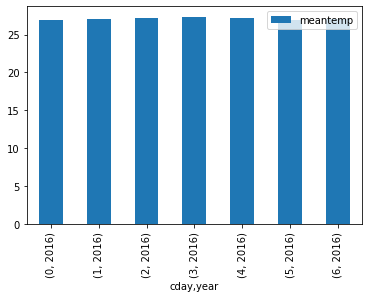

In [6]:
import matplotlib.pyplot as plt

year = df.groupby(['year']).mean()
month = df.groupby(['month']).mean()
meantemp_year = year['meantemp']
meantemp_month = month['meantemp']
df_day.drop(columns=['y_value', 'humidity', 'wind_speed', 'meanpressure', 'wind_speed', 'month','season_winter','season_summer', 'season_fall', 'season_rainy'], axis=1, inplace=True)
is_2016 =  df_day['year']==2016
df_day_2016 = df_day[is_2016]
df_day_2016.groupby(['cday', 'year']).mean().plot(kind='bar')
plt.show()

Se puede apreciar que la información del día anterior (año 2016) no es relevante por si sola según la media de temperaturas por día, ya que podría predecir que las temperaturas serían constantes en ese aspecto.

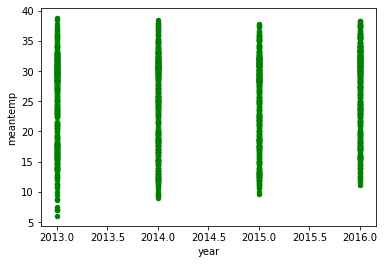

In [7]:
df.plot(kind='scatter',x='year',y='meantemp',color='green')
plt.show()

Se puede apreciar que en general la temperatura tras los años son menos dispersas en torno a temperaturas más altas (sobre los 20° en general) y las mínimas son aún más altas, por lo que la predicción en el tiempo tiene que tener previsto este crecimiento.

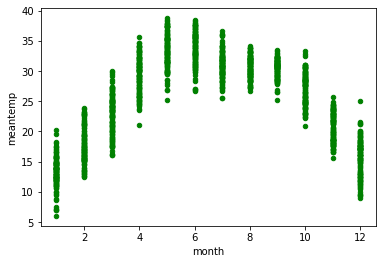

In [8]:
df.plot(kind='scatter',x='month',y='meantemp',color='green')
plt.show()

Tener en cuenta los mese es fundamental, ya que denota los periodos de más altas temperaturas, en cuanto a mínimas y máximas, por lo que este rango es el que tendría coherencia predecir, pero debilitando el modelo por posibles fenómenos naturales (causando outliers).

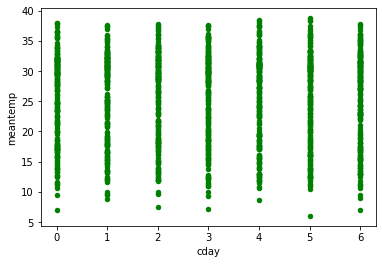

In [9]:
df.plot(kind='scatter',x='cday',y='meantemp',color='green')
plt.show()

Las temperaturas medias de los días en el rango de tiempo estudiado, arrojan un rango 'válido' de temperaturas a predecir, pero es apresurado decir a priori que sabado es el día más caluroso o que domingo será más frío por que el sabado hubo X temperatura, aunque si se puede apreciar la densidad de temperatura media irregular que hace descartar la desición de predecir la temperatura del día SOLO dado el día anterior.

> b) Entrene un solo Árbol de Regresión de múltiples niveles para resolver el problema. Defina un Árbol **no regularizado** (como el que no tiene límites en su profundidad) y otro Árbol **regularizado** (variando los hiper-parámetros que prefiera, por ejemplo, los más comunes como la profundidad, el número mínimo de datos para realizar *split* o el número mínimo de datos en cada hoja). Además comente sobre la ventaja de usar un árbol de decisión respecto a la escala de los datos ¿Porqué no es necesario escalar los datos?
```python
import numpy as np
def RMSE(ytrue,ypred):
    return np.sqrt(np.mean(np.square(ytrue - ypred)) )
from sklearn.tree import DecisionTreeRegressor as Tree
model_unr = Tree() #unregularized model -- default parameters
model_unr.fit(X_train,y_train)
... #define your regularized tree model
``` 

In [10]:
import numpy as np
def RMSE(ytrue,ypred):
    return np.sqrt(np.mean(np.square(ytrue - ypred)) )
from sklearn.tree import DecisionTreeRegressor as Tree
model_unr = Tree() #unregularized model -- default parameters
model_unr.fit(X_train,y_train)
print(f'Árbol No regularizado: {model_unr.score(X_val, y_val)}')

Árbol No regularizado: 0.8900630876395249


In [11]:
model_reg = Tree(max_depth=4, min_samples_split=3, random_state=0)
model_reg.fit(X_train,y_train)
print(f'Árbol regularizado: {model_reg.score(X_val, y_val)}')

Árbol regularizado: 0.9428168125618203


Su ventaja principal es que la dimensionalidad del dataset sea baja, ya que para una dimensionalidad alta o mejor dicho "no baja" el problema se convierte en uno NP-hard.

> c) Para evaluar la calidad de predicción en este problema se utilizará la métrica *Root Mean Squared Error* (RMSE), indicando un error en la escala real de la temperatura. Como los datos de validación siguen con el orden temporal, visualice esa predicción a lo largo del tiempo. Comente sobre los resultados comparando la regularización *vs* el no regularizar.
```python
y_train_hat = model.predict(X_train)
y_val_hat = model.predict(X_val)
print("RMSE train= ",RMSE(y_train,y_train_hat))
print("RMSE val= ",RMSE(y_val,y_val_hat))
import matplotlib.pyplot as plt
plt.figure(figsize=(8,5))
plt.plot(y_val, '.-' ,label="True values")
plt.plot(y_val_hat, '.-' ,label="Pred values")
plt.legend()
plt.show()
```

RMSE train=  0.0
RMSE val=  2.349239210314766


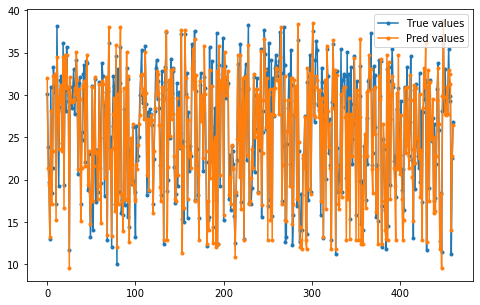

In [12]:
y_train_hat = model_unr.predict(X_train)
y_val_hat = model_unr.predict(X_val)
print("RMSE train= ",RMSE(y_train,y_train_hat))
print("RMSE val= ",RMSE(y_val,y_val_hat))
import matplotlib.pyplot as plt
plt.figure(figsize=(8,5))
plt.plot(y_val, '.-' ,label="True values")
plt.plot(y_val_hat, '.-' ,label="Pred values")
plt.legend()
plt.show()

RMSE train=  1.6529851326308735
RMSE val=  1.6942974335956573


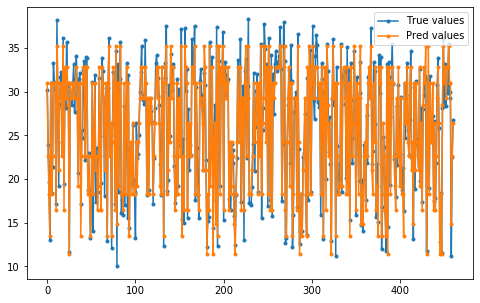

In [13]:
y_train_hat = model_reg.predict(X_train)
y_val_hat = model_reg.predict(X_val)
print("RMSE train= ",RMSE(y_train,y_train_hat))
print("RMSE val= ",RMSE(y_val,y_val_hat))
import matplotlib.pyplot as plt
plt.figure(figsize=(8,5))
plt.plot(y_val, '.-' ,label="True values")
plt.plot(y_val_hat, '.-' ,label="Pred values")
plt.legend()
plt.show()

El modelo no regularizado, se le tienden a escapar las temperaturas altas, este predice valores inferiores a los que realmente son, por lo que es muy sensible a la densidad media de la temperatura, y predice temperaturas menos calidas de lo que son realmente, en cambio el regularizado se nota que cubre más temperaturas predichas pero aún así se le escapan las altas temperaturas, este fija la temperatura de 35° como tope, por lo que el arbol debe haber decidido que dada cualquier condicion esta temperatura nunca se sobrepasa.

> d) Entrene un ensamblado de árboles de múltiples niveles, mediante la técnica de **Bagging**, compare el Árbol **no regularizado** con el **regularizado** (*seteando los hiper-parámetros en base a lo experimentado anteriormente en b)*) ¿Qué debería suceder? ¿Se visualiza *overfitting*? Varíe la cantidad de árboles de decisión utilizados en el ensamblado (*n estimators*), realice un gráfico resumen del RMSE de entrenamiento y validación en función de este hiper-parámetro.

In [14]:
from sklearn.ensemble import BaggingRegressor
Bagging_unr = BaggingRegressor(base_estimator=Tree(), n_estimators=10, n_jobs=-1)
Bagging_unr.fit(X_train,y_train)
y_train_predicted = Bagging_unr.predict(X_train)
y_test_predicted_pruned_trees = Bagging_unr.predict(X_val)
mse_train = RMSE(y_train, y_train_predicted)
mse_test = RMSE(y_val, y_test_predicted_pruned_trees)
print("Bagging no regularizado Train MSE: {} Test MSE: {}".format(mse_train, mse_test))

Bagging_reg = BaggingRegressor(base_estimator=Tree(max_depth=4, min_samples_split=3, random_state=0), n_estimators=10, n_jobs=-1)
Bagging_reg.fit(X_train,y_train)
y_train_predicted = Bagging_reg.predict(X_train)
y_test_predicted_pruned_trees = Bagging_reg.predict(X_val)
mse_train = RMSE(y_train, y_train_predicted)
mse_test = RMSE(y_val, y_test_predicted_pruned_trees)
print("Bagging regularizado Train MSE: {} Test Val MSE: {}".format(mse_train, mse_test))

Bagging no regularizado Train MSE: 0.7418357749983785 Test MSE: 1.776401681842618
Bagging regularizado Train MSE: 1.5742345506631803 Test Val MSE: 1.5569745714736465


Se puede apreciar que al no regularizar aumenta el overfiting, ya uqe el error de los datos de test es bastante mayor que los de prueba, y al regularizar estos valores se acercan (por lo que el overfitting disminuye) y el error en datos reales decrece, pero aún así no son totalmente optimos los resulatdos.

In [15]:
mse_train_list = []
mse_test_list = []
for i in range(20):
    Bagging_reg = BaggingRegressor(base_estimator=Tree(max_depth=4, min_samples_split=3, random_state=0), n_estimators=i+1, n_jobs=-1)
    Bagging_reg.fit(X_train,y_train)
    y_train_predicted = Bagging_reg.predict(X_train)
    y_test_predicted_pruned_trees = Bagging_reg.predict(X_val)
    mse_train_list.append(RMSE(y_train, y_train_predicted))
    mse_test_list.append(RMSE(y_val, y_test_predicted_pruned_trees))

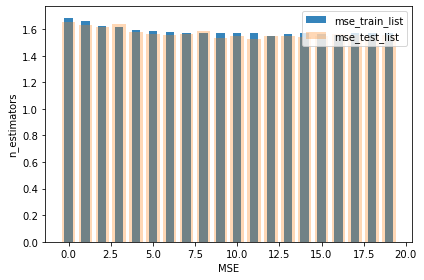

In [16]:
plt.bar(range(20),mse_train_list, 0.5, alpha=0.9, label='mse_train_list')
# plt.xlabel('MSE')
# plt.ylabel('n_estimators')

plt.bar(range(20),mse_test_list, 0.8, alpha=0.3, label='mse_test_list')
plt.xlabel('MSE')
plt.ylabel('n_estimators')
plt.legend()
plt.tight_layout()
plt.show()

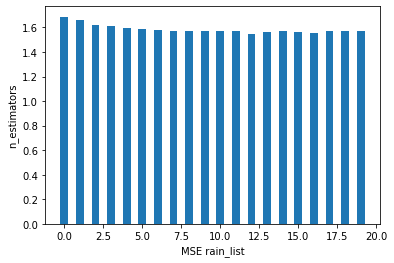

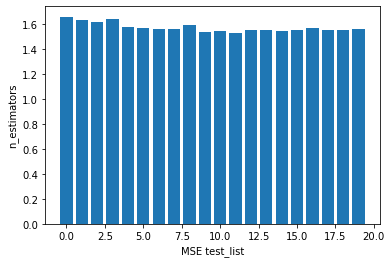

In [17]:
plt.bar(range(20),mse_train_list, 0.5, label='mse_train_list')
plt.xlabel('MSE rain_list')
plt.ylabel('n_estimators')
plt.show()
plt.bar(range(20),mse_test_list, 0.8, label='mse_test_list')
plt.xlabel('MSE test_list')
plt.ylabel('n_estimators')
plt.show()

> e) Entrene un ensamblado de árboles de múltiples niveles, mediante la técnica de **AdaBoost**, compare el Árbol **no regularizado** con el **regularizado** (*seteando los hiper-parámetros en base a lo experimentado anteriormente en d)* ¿Se visualiza *overfitting*? ¿Qué técnica utiliza la librería de sklearn, *re-muestrear* o *pesar* ejemplos? ¿Qué le parece más sensato?. Varíe la cantidad de árboles de decisión utilizados en el ensamblado (*n estimators*), realice un gráfico resumen del RMSE de entrenamiento y validación en función de este hiper-parámetro. Compare y analice con la técnica utilizada en d).

In [18]:
from sklearn.ensemble import AdaBoostRegressor
model_unr_Ada = AdaBoostRegressor(base_estimator=Tree(), n_estimators=10)
model_unr_Ada.fit(X_train,y_train)
y_train_predicted = model_unr_Ada.predict(X_train)
y_test_predicted_pruned_trees = model_unr_Ada.predict(X_val)
mse_train = RMSE(y_train, y_train_predicted)
mse_test = RMSE(y_val, y_test_predicted_pruned_trees)
print("AdaBoost no regularizado Train MSE: {} Test Val MSE: {}".format(mse_train, mse_test))

AdaBoost no regularizado Train MSE: 0.22530779561564246 Test Val MSE: 1.8557503428797828


In [19]:
model_reg_Ada = AdaBoostRegressor(base_estimator=Tree(max_depth=4, min_samples_split=3, random_state=0), n_estimators=10)
model_reg_Ada.fit(X_train,y_train)
y_train_predicted = model_reg_Ada.predict(X_train)
y_test_predicted_pruned_trees = model_reg_Ada.predict(X_val)
mse_train = RMSE(y_train, y_train_predicted)
mse_test = RMSE(y_val, y_test_predicted_pruned_trees)
print("AdaBoost regularizado Train MSE: {} Test Val MSE: {}".format(mse_train, mse_test))

AdaBoost regularizado Train MSE: 1.539226681623651 Test Val MSE: 1.6863989932824555


Se puede visualizar un overfiting extremo en el AdaBoost no regularizado y en el regularizado tiene una diferencia de 0.1 con respecto al set de validación. La técnica de sklearn es que ajusta copias adicionales del clasificador en el mismo conjunto de datos pero donde los pesos de las instancias clasificadas incorrectamente se ajustan de modo que los clasificadores posteriores se centren más en casos difíciles, pero no parece sensato centrar tanto el modelo en clasificar los incorrectos, ya que esto produce el claro overfitting mostrado anteriormente.

In [20]:
mse_train_list = []
mse_test_list = []
for i in range(30):
    AdaBoost_reg = AdaBoostRegressor(base_estimator=Tree(max_depth=4, min_samples_split=3, random_state=0), n_estimators=i+1)
    AdaBoost_reg.fit(X_train,y_train)
    y_train_predicted = AdaBoost_reg.predict(X_train)
    y_test_predicted_pruned_trees = AdaBoost_reg.predict(X_val)
    mse_train_list.append(RMSE(y_train, y_train_predicted))
    mse_test_list.append(RMSE(y_val, y_test_predicted_pruned_trees))

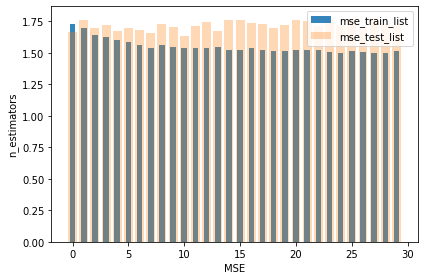

In [21]:
plt.bar(range(30),mse_train_list, 0.5, alpha=0.9, label='mse_train_list')
# plt.xlabel('MSE')
# plt.ylabel('n_estimators')

plt.bar(range(30),mse_test_list, 0.8, alpha=0.3, label='mse_test_list')
plt.xlabel('MSE')
plt.ylabel('n_estimators')
plt.legend()
plt.tight_layout()
plt.show()

Se puede divisar que el error de entrenamiento de la sección d) a medida que aumentan los estimadores este converge a un error 'mínimo posible' pero en este caso decae rapidamente el error pero luego sube y se vuelve iregular, por lo que en esta técnica entre más estimadores, menos accuracy tiene.

> f) Pruebe otra técnica de ensamblado dedicada a árboles de decisión, que combina el muestreo *boostrap* de *Bagging* con muestreo sobre las *features*: **Random Forest**, compare el Árbol **no regularizado** con el **regularizado** ¿Se visualiza *overfitting*?. Varíe la cantidad de árboles de decisión utilizados en el ensamblado (*n estimators*), realice un gráfico resumen del RMSE de entrenamiento y validación en función de este hiper-parámetro.

In [22]:
from sklearn.ensemble import RandomForestRegressor
model_unr_Forest = RandomForestRegressor(n_estimators=10, n_jobs=-1, oob_score=True,)
model_unr_Forest.fit(X_train,y_train)
... #define your regularized random forest model

model_reg_Forest_sqrt = RandomForestRegressor(warm_start=True, max_features='sqrt',
                               oob_score=True,
                               random_state=0)

model_reg_Forest_sqrt.fit(X_train,y_train)
model_reg_Forest_sqrt.score(X_val, y_val)

c:\users\gabri\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\ensemble\_forest.py:815: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


0.927557891097661

RMSE model_reg_Forest_sqrt train=  0.6518959681490606
RMSE model_reg_Forest_sqrt val=  1.9070014163157478


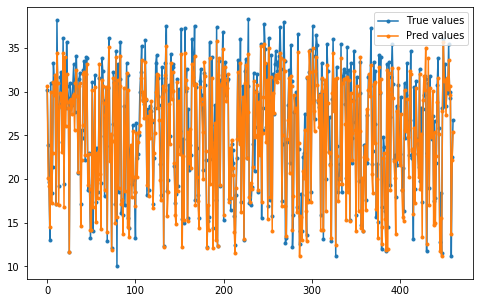

In [23]:
y_train_hat = model_reg_Forest_sqrt.predict(X_train)
y_val_hat = model_reg_Forest_sqrt.predict(X_val)
print("RMSE model_reg_Forest_sqrt train= ",RMSE(y_train,y_train_hat))
print("RMSE model_reg_Forest_sqrt val= ",RMSE(y_val,y_val_hat))
import matplotlib.pyplot as plt
plt.figure(figsize=(8,5))
plt.plot(y_val, '.-' ,label="True values")
plt.plot(y_val_hat, '.-' ,label="Pred values")
plt.legend()
plt.show()

En este caso, se visualiza el peor modelo, este tiende a tirar overfiting y los errores son burdos.

> g) Verifique que el **OOB error** (*out of bag error*) de los ensambladores que utilizan la técnica *boostrap* puede ser una alternativa como métrica de generalización, compare con el error calculado sobre el conjunto de validación (o en su defecto *cross validation*).

In [24]:
oob_error = model_reg_Forest_sqrt.oob_score_
val_error = model_reg_Forest_sqrt.score(X_val,y_val)
print("OOB error: ",oob_error)
print ("Val error: ",val_error)

OOB error:  0.945551458880202
Val error:  0.927557891097661


In [25]:
y_train_predicted = model_reg_Forest_sqrt.predict(X_train)
y_test_predicted_pruned_trees = model_reg_Forest_sqrt.predict(X_val)
mse_train = RMSE(y_train, y_train_predicted)
mse_test = RMSE(y_val, y_test_predicted_pruned_trees)
print("Random forest sqrt regularizado Train MSE: {} Test Val MSE: {}".format(mse_train, mse_test))

Random forest sqrt regularizado Train MSE: 0.6518959681490606 Test Val MSE: 1.9070014163157478


Se puede observar que OOB no produce un overfitting, y que mejora considerablemente en relación a la utilización de Random forest.

> h) Defina otra forma de combinar los valores que entregan los ensamblados al hacer predicciones y compare con lo que se hace actualmente, por ejemplo *Bagging* realiza el voto de la mayoría para clasificación y promedio para regresión, *AdaBoost* realiza una combinación ponderada de cada clasificador dependiendo de su *habilidad* (desempeño para clasificar el conjunto de entrenamiento). Se puede inspirar desde clásicos estadísticos, como entregar el primer cuartíl ($Q_1$) si al ensamblado le cuesta predecir valores bajos, o el segundo cuartil ($Q_2$) o mediana para ser robusto a predicciones atípicas de modelos.  

In [28]:
def combine_predictions(predictions):
    new_predictions = []
    m = np.empty((0,0))
    for i in predictions:
        if m.shape == (0,0):
            m = i[np.newaxis,:]
        else:
            m = np.concatenate((m, i[np.newaxis,:]), axis=0)
    for j in range(m.shape[1]):
        new_predictions.append(np.percentile(m[:,j], 70))
        #new_predictions.append(np.quantile(m[:,j],0.75))
    return new_predictions

list_estimators = model_reg_Forest_sqrt.estimators_
list_predictions = [estimator.predict(X_val) for estimator in list_estimators]
list_predictions_train = [estimator.predict(X_train) for estimator in list_estimators]
new_predictions = combine_predictions(list_predictions)
new_predictions_train = combine_predictions(list_predictions_train)
print("RMSE y_train= ",RMSE(y_train, new_predictions_train))
print("RMSE val= ",RMSE(y_val, new_predictions))

RMSE y_train=  0.7123030067950012
RMSE val=  1.6985953977774686


Considerando el percentil 70 como métrica se puede lograr bajar el error de predicción de el peor modelo que tenemos y disminuir su overfitting

> i) Si se cuenta con una gran cantidad de modelos en el ensamblado, por ejemplo $T>100$, se puede crear un intervalo de confianza de la predicción a través de todos estos valores, asumiendo una distribución Normal centrada en la media muestral de las predicciones, con desviación estándar muestral en las predicciones. El intervalo de confianza entrega más información que un único valor puntual de predicción. Visualice un intervalo de confianza al 95% de probabilidad en la predicción a lo largo de la serie de tiempo de validación, comente. Al asumir una distribución Normal, también puede explorar el tomar como predicción del ensamblado el muestreo sobre la distribución Normal creada entorno a los datos muestrales.

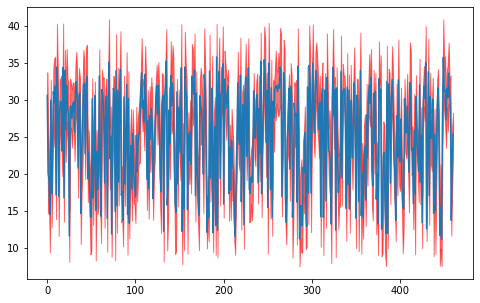

In [29]:
X_val_est = np.vstack(list_predictions).T #has shape=(N_test, n_estimator), with n_estimator>100
from scipy.stats import norm
interv_val = []
for n in range(X_val.shape[0]):
    low, up = norm.interval(0.95, loc=np.mean(X_val_est[n]), scale=np.std(X_val_est[n]))
    interv_val.append([low,up])
interv_val = np.asarray(interv_val)
x = np.arange(X_val_est.shape[0])
plt.figure(figsize=(8,5))
plt.plot(x, np.mean(X_val_est, axis=1))
plt.fill_between(x, interv_val[:,0], interv_val[:,1], color='r', alpha=.55)
plt.show()

Se puede asegurar con un 95% de certeza que la temperatura estará en el intervalo entre 10 y 40 °C, además se observa que siempre el promedio está dentro del intervalo de confianza, y por lo tanto es una buena métrica sacar el promedio como "desición" (predicción) del comite.

>  j) Evalúe y visualice la predicción del mejor modelo encontrado para resolver este problema, en el conjunto de pruebas. Además, compare y analice las distintas maneras con las que se resolvió el problema, incluya las decisiones que conlleva y los resultados que reflejan.

In [30]:
df = pd.read_csv("DailyDelhiClimateTest.csv")

print("Bagging regularizado Train MSE: {} Test Val MSE: {}".format(mse_train, mse_test))
print(f'Árbol No regularizado: {Bagging_reg.score(X_val, y_val)}')


Bagging regularizado Train MSE: 0.6518959681490606 Test Val MSE: 1.9070014163157478
Árbol No regularizado: 0.9517002075534579


Bagging es el vencedor en este problema, dado que los modelos con los que compite, tienden a hacer overfiting, y bagging se caracteriza por lo contrario, esto también se puede deber a que aumentamos la dimensionalidad del problema agregando caracteristicas nuevas, además usamos arboles de desiciones poco regularizado con varios niveles, además tenemos un dataset con alta varianza dónde las temperaturas se pueden dar entre lso 10 y 40 grados celcius y el sesgo es bajo ya que en distintas temporadas (verano, invierno, otoño, primavera) la densidad de probabilidad de distinto rango de temperaturas es mayor, por ejemplo en verano es más probable que las temperaturas varien por sobre los 20°C y no bajen de ahí.

<a id="segundo"></a>
## 2. Detección de acoso en *Twitter*
---
En las redes sociales muchas veces se encuentra con un cierto comportamiento indeseable para los usuarios, tal como racismo, misógeno, grupos de odio o *trolls*. El poder detectar de manera automática ciertos patrones en el comportamiento para tomar una acción debe ser crucial para reducir el tiempo y esfuerzo humano. En esta actividad se trabajará sobre *tweets* la red social de *twitter* para detectar comportamiento *online* de acoso (*harassment*), que por lo general, incluye *flaming* como lenguaje abusivo o insultos, *doxing* como mostrar la información personal de una mujer, por ejemplo el domicilio o número de teléfono, la suplantación o la vergüenza pública por destruir la reputación de las personas.

<img src="https://kidshelpline.com.au/sites/default/files/bdl_image/header-T-OH.png" title="Title text" width="45%"  />

En algunos problemas como este, el comportamiento a detectar puede ser asociado a una anomalía (*outlier*) del comportamiento normal de los usuarios en las redes sociales. Esto es una de las causas de la dificultad del problema, puesto que es **altamente desbalanceado**, donde aproximadamente un 10% de los *tweets* corresponden a acoso (*harassment*).

Los datos trabajados corresponderan a *tweets* etiquetados como *harassment* (con valor 1) o no (con valor 0) -- la tarea a detectar--. Además si desea utilizar, se incluye la información del tipo de *harassment* en el conjunto de entrenamiento como atributos extras. El conjunto de pruebas solo contiene los *tweets* a ser etiquetados.

---
### Importante
* Esta pregunta será evaluada **sólo** por los resultados (*submission*) obtenidos en el desafío presentado en __[Kaggle](https://www.kaggle.com/c/t1-ml/)__ a través del siguiente __[link](https://www.kaggle.com/t/91f8c0c746f945cfa510b88469df4d67)__. Las notas serán entregadas a través de la siguiente fórmula:  
$$ Nota(i) = 100\cdot max\left(0.55; s^{(1-i)} \right), \ \ con \ \ i \in \{1,\ \ldots, N\}$$
Con la escala de decaimiento es $ s = 1.05$ y con $i$ su lugar en el *ranking*.

* La métrica de evaluación será el *f1 score* [[3]](#refs) sobre la clase positiva (*harassment*), así evaluar la calidad del modelo sobre la clase minoritaria, lo cual también debiera reflejar el desempeño de la clase negativa (al ser el complemento).
```python
from  sklearn.metrics import f1_score
f1_score(y_test, y_pred, average='binary')
```

* El archivo de *submission* debe contener las predicciones de *harassment* (0 o 1) a cada dato de pruebas, además de la columna de *id* asociado al dato, iniciando en 1. Si leyó de manera ordenada el archivo de pruebas, se puede generar de la siguiente manera:
```python
df_aux = pd.DataFrame()
df_aux["id"] = np.arange(1, 1+y_pred.shape[0])
df_aux["harassment"] = y_pred.astype('int')
df_aux.to_csv("test_estimation.csv", index=False)
```

* Se solicita realizar **un solo** *submission* por grupo, para no perjudicar la nota de sus compañeros en el *ranking*. Además de ser claros con sus nombres de entrega para no asignarles de manera errónea su correspondiente nota.

* **Si no realiza *submission* a Kaggle su nota en esta sección será de 0**.

* **Si su *score* alcanzado es menor o igual al *benchmark* random que se encuentra en el *ranking*, su nota en esta sección será de 25**

<a id="refs"></a>
## Referencias
[1] https://scikit-learn.org/stable/modules/ensemble.html  
[2] https://scikit-learn.org/stable/modules/tree.html  
[3] http://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html  
[4] https://towardsdatascience.com/methods-for-dealing-with-imbalanced-data-5b761be45a18